In [1]:
!pip install torchdiffeq

In [2]:
import os
import argparse
import time
import psutil
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from torchdiffeq import odeint

In [3]:
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [4]:
train_mat = scipy.io.loadmat('../input/npdetest/S_train_20.mat')
params_train_mat = scipy.io.loadmat('../input/npdetest/params_train_20.mat')
test_mat = scipy.io.loadmat('../input/npdetest/S_test_20_extended.mat')
params_test_mat = scipy.io.loadmat('../input/npdetest/params_test_20_extended.mat')

In [5]:
train_tensor = torch.tensor(train_mat['S'])
params_train_data = torch.tensor(params_train_mat['I'])
test_data = torch.tensor(test_mat['S'])
params_test_data = torch.tensor(params_test_mat['I'])

In [6]:
train_data = torch.transpose(train_tensor[:,:350],0, 1).unsqueeze(1)
test_data = torch.transpose(train_tensor[:,350:400],0, 1).unsqueeze(1)

In [7]:
train_data.shape,test_data.shape

(torch.Size([350, 1, 256]), torch.Size([50, 1, 256]))

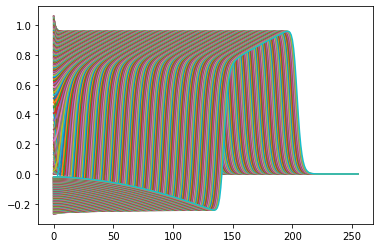

In [8]:
for i in range(0,350):
   plt.plot(train_data[i,:,:].flatten())
   #print(params_train_data[i])

In [9]:
data_size = train_data.shape[0]
print(data_size)
batch_time = 20
batch_size = 32
n_hidden = 50
method = 'dopri8'
test_freq = 50
epochs = 1000

350


In [10]:
def get_batch():
    batch_t = torch.arange(batch_time).float()
    s = torch.from_numpy(np.random.choice(np.arange(data_size-batch_time), batch_size, replace=False))
    
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

In [11]:
def get_batch_test(t0,test_batch_time):
    batch_t = torch.arange(test_batch_time-t0).float()
    s = torch.tensor([t0])
    batch_u0 = train_data[s,:,:].float()
    batch_u = torch.stack([train_data[s+i,:,:] for i in range(test_batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s

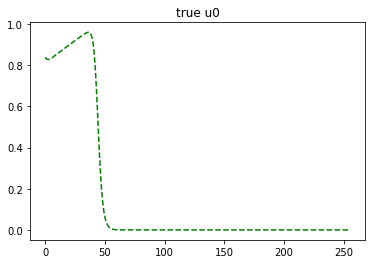

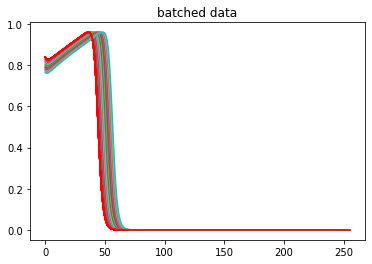

In [12]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].cpu().flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')

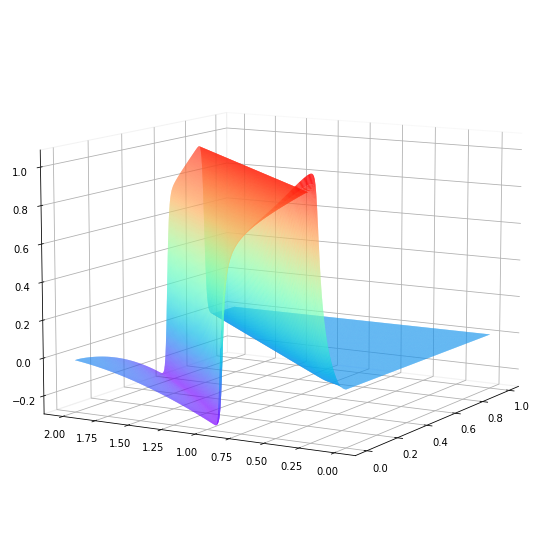

In [13]:
t = np.linspace(0, 2, data_size)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000,alpha=1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(10, 210)

In [14]:
batch_u0.shape

torch.Size([32, 1, 256])

In [15]:
# DIM TEST
input_ = batch_u0.cpu()
output = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same',dilation=1)(input_)
output = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same',dilation=1)(output)
output1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same',dilation=1)(input_)
output1 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same',dilation=1)(output1)
output2 = output+output1
output2.shape

torch.Size([32, 1, 256])

In [16]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(256, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 256)
        )

        
        self.nfe=0
        self.net[0].weight.data.normal_(0.0, 1/n_hidden)
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 1/n_hidden)
        self.net[2].bias.data.fill_(.0)

    def forward(self, t, y):
        self.nfe += 1
        return self.net(y)

In [17]:
class ConvODEFunc(nn.Module):
    def __init__(self):
        super(ConvODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='same'),
            nn.Tanh(),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding='same')
        )
        self.net[0].weight.data.normal_(0.0, 1/(16*3*3))
        self.net[0].bias.data.fill_(.0)
        self.net[2].weight.data.normal_(0.0, 1/(16*3*3))
        self.net[2].bias.data.fill_(.0)
        
    def forward(self, t, y):
        return self.net(y)

In [18]:
func = ConvODEFunc().to(device)

In [19]:
ii = 0
lrate = 1e-3


optimizer = optim.Adam(func.parameters(), lr=lrate)

loss_array = []
itr_time = []
start = time.time()

for itr in range(1, epochs + 1):

    start_itr = time.time()

    batch_u0, batch_u, batch_t, s = get_batch()
    pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)

    loss = torch.mean(torch.pow(pred_u - batch_u,2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    itr_time.append(time.time()-start_itr)
    loss_array.append(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            print('Iter ' + str(itr)+'/'+str(epochs) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5)))
            #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
            #       ii += 1

total_elapsed_time = time.time()-start

Iter 50/1000	|  Loss: 0.015621	|  lr: 0.001	|  itr time: 0.26743
Iter 100/1000	|  Loss: 0.004202	|  lr: 0.001	|  itr time: 0.59325
Iter 150/1000	|  Loss: 0.004238	|  lr: 0.001	|  itr time: 1.16883
Iter 200/1000	|  Loss: 0.004635	|  lr: 0.001	|  itr time: 1.32124
Iter 250/1000	|  Loss: 0.003388	|  lr: 0.001	|  itr time: 1.5739
Iter 300/1000	|  Loss: 0.004341	|  lr: 0.001	|  itr time: 1.89251
Iter 350/1000	|  Loss: 0.00372	|  lr: 0.001	|  itr time: 1.44705
Iter 400/1000	|  Loss: 0.003124	|  lr: 0.001	|  itr time: 1.49879
Iter 450/1000	|  Loss: 0.002651	|  lr: 0.001	|  itr time: 1.63693
Iter 500/1000	|  Loss: 0.001784	|  lr: 0.001	|  itr time: 1.51413
Iter 550/1000	|  Loss: 0.00252	|  lr: 0.001	|  itr time: 1.28028
Iter 600/1000	|  Loss: 0.00129	|  lr: 0.001	|  itr time: 1.28534
Iter 650/1000	|  Loss: 0.001274	|  lr: 0.001	|  itr time: 1.25748
Iter 700/1000	|  Loss: 0.001738	|  lr: 0.001	|  itr time: 1.41748
Iter 750/1000	|  Loss: 0.000969	|  lr: 0.001	|  itr time: 1.39468
Iter 800/1000	|

In [20]:
batch_u0, batch_u, batch_t, s = get_batch_test(100,200)
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

In [21]:
batch_u.shape

torch.Size([200, 1, 1, 256])

<Figure size 432x288 with 0 Axes>

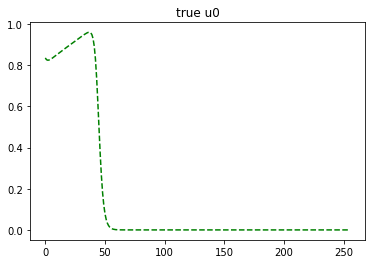

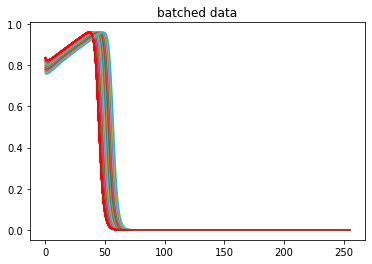

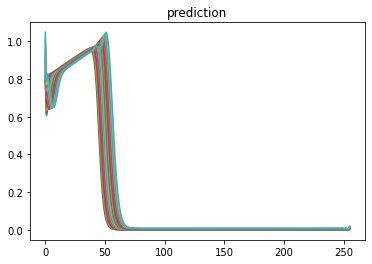

In [22]:
plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 0
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(20):
  plt.plot(pred_u[j,batch_element,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])

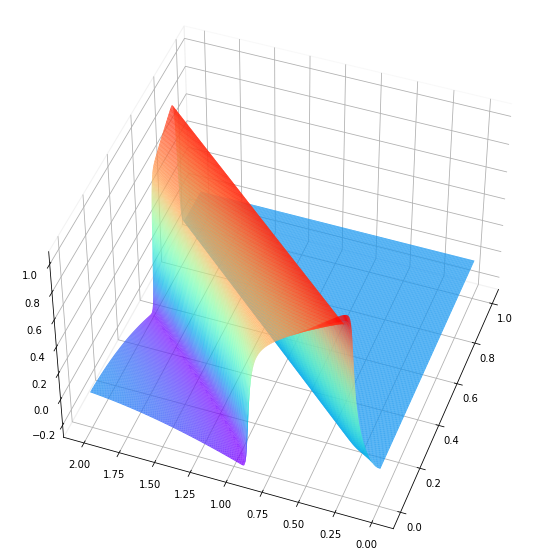

In [23]:
t = np.linspace(0, 2, data_size)
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data.squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(45, 200)

In [24]:
pred_u.shape

torch.Size([100, 1, 1, 256])

In [25]:
t0 = 300
pred_t = torch.arange(data_size-t0).float().to(device)   
pred_u0 = train_data[t0,:,:].unsqueeze(0).float().to(device)   
pred_u0.shape

torch.Size([1, 1, 256])

In [26]:
pred_u = odeint(func, pred_u0, pred_t,method=method).to(device)   

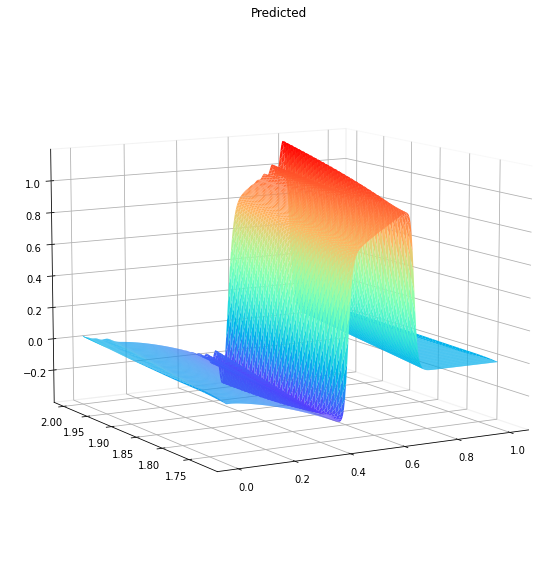

In [27]:
t = np.linspace(0, 2, data_size)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = pred_u.squeeze(1).squeeze(1).detach().cpu().numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('Predicted')
ax.view_init(10, 240)

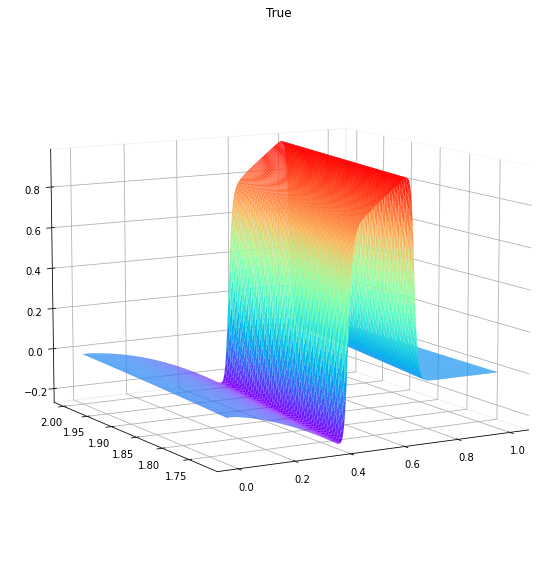

In [28]:
t = np.linspace(0, 2, data_size)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = train_data[t0:,:].squeeze(1).numpy()
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('True')
ax.view_init(10, 240)

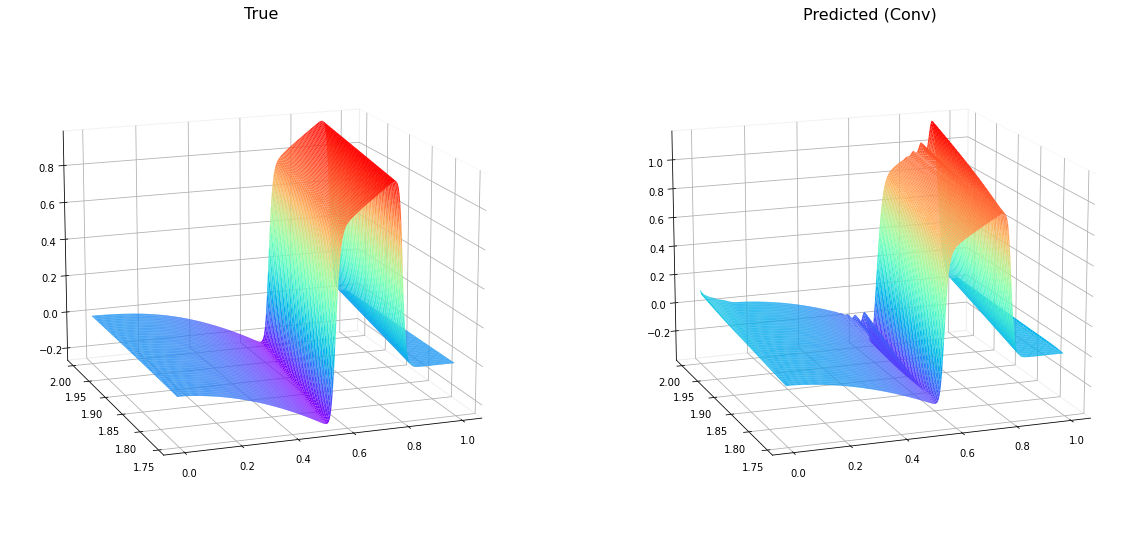

In [29]:
t0 = 350
angle1 = 15
angle2 = 250
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = test_data.squeeze(1).numpy()
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.set_title('True',fontsize=16)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(angle1, angle2)

pred_t = torch.arange(50).float().to(device)
pred_u0 = test_data[0,:,:].unsqueeze(0).float().to(device)
pred_u0.shape
pred_u = odeint(func, pred_u0, pred_t,method=method).to(device)   
t = np.linspace(0, 2, 400)[t0:]
x = np.linspace(0, 1, 256)

X, Y = np.meshgrid(x, t)
Z = pred_u.squeeze(1).squeeze(1).detach().cpu().numpy()

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.rainbow,linewidth=0, antialiased=True,rcount=1000, ccount=1000)
ax.set_title('Predicted (Conv)',fontsize=16)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(angle1, angle2)

plt.savefig('double.png',dpi=200)

In [30]:
mse = torch.mean(torch.pow(test_data-pred_u.cpu().squeeze(1),2))
mse

tensor(0.0010, dtype=torch.float64, grad_fn=<MeanBackward0>)

<Figure size 432x288 with 0 Axes>

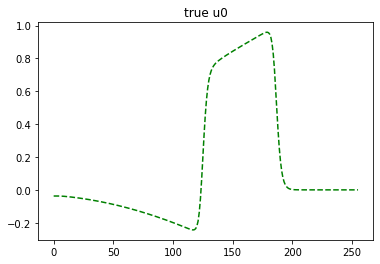

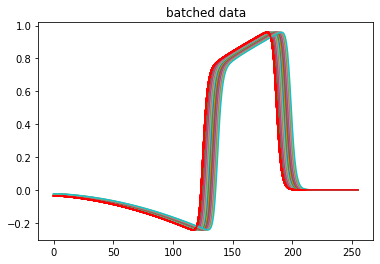

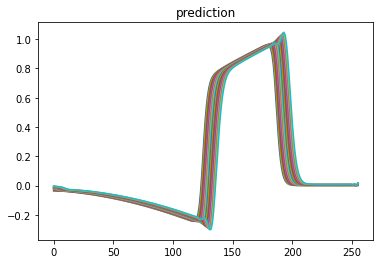

In [31]:
batch_u0, batch_u, batch_t, s = get_batch()
batch_u0.shape, batch_u.shape, batch_t.shape
pred_u = odeint(func, batch_u0, batch_t,method=method).to(device)   

plt.figure().patch.set_facecolor('#FFFFFF')

batch_element = 2
i = s[batch_element]
plt.figure()
plt.title('true u0')
plt.plot(train_data[i,:,:].flatten(),'--g',label='true_u0')
plt.figure()
plt.title('batched data')
for j in range(batch_time):
  plt.plot(batch_u[j,batch_element,:,:].cpu().flatten())
  plt.plot(batch_u0[batch_element,:,:].cpu().flatten(),'-r',label='u0')
plt.savefig('target.png',dpi=200)

plt.figure()
plt.title('prediction')
for j in range(batch_time):
  plt.plot(pred_u[j,batch_element,:,:].cpu().detach().flatten())

plt.savefig('pred.png',dpi=200)
#print(params_train_data[i])